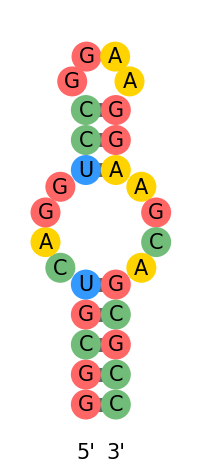

Note: This parser ignores pseudoknots and isolated base pairs.
      Please ensure only standard nested base pairs use '()'.
      Pseudoknots like '[', ']', '{', '}' are ignored.

Hairpin Loops:
{'range': (12, 15), 'sequence': 'GGAA'}

Internal Loops:
{'stem': (4, 23), 'branches': [(5, 8, 'CAGG'), (19, 22, 'AGCA')], 'branch_count': 2}

Bulge Loops:

Multibranch Loops:

5' Dangling End:

3' Dangling End:

=== Internal Loop Substructure 1 ===
Sequence:      GGCGUCAGGUCCGGAAGCAGCGCC
Dot-bracket:   (((((....((()))....)))))
Stems:
  [(0, 27), (1, 26), (2, 25), (3, 24), (4, 23)]
  [(9, 18), (10, 17), (11, 16)]
Loop Info:     {'stem': (4, 23), 'branches': [(5, 8, 'CAGG'), (19, 22, 'AGCA')], 'branch_count': 2}
*****
    id  Li-1  Li  Li+1  A(Li-1)  A(Li)  A(Li+1)  G(Hi,Hi+1)  G(Hi)  G(Hi+1)  \
0   1     4   4     4        1      1        1         8.1  -7.01    -1.07   

   LHi  LHi+1  N_way  coaxial_prob  
0    5      3      0      0.532337  
The two stems in this Internal loop are predicted

In [5]:
"""
Title: gCoSRNA - Predicting Coaxial Stacking in RNA Secondary Structures via Pseudo 2-Way Junctions

Description:
This program, gCoSRNA, takes an RNA secondary structure as input (represented by a dot-bracket notation),
parses it into multiple pseudo 2-way junction substructures (i.e., regions where two stems are potentially coaxially stacked),
computes structural and sequence-derived features for each substructure, predicts the probability of coaxial stacking using a trained machine learning model,
and finally assigns a consistent set of coaxial stacking pairs by resolving conflicts across all substructures.

Output:
A list of coaxially stacked stem pairs.
"""
from typing import List, Tuple, Dict, Union
from collections import deque, defaultdict
from draw_rna.ipynb_draw import draw_struct
from math import log
import math 
import pandas as pd
import joblib
import os
# ---------------------------
# Free energy of base-stacking from Turner's parameters
# ---------------------------
STACKING_ENERGY = {
    'AUAU': -0.93, 'UAUA': -0.93, 'AUUA': -1.10, 'UAAU': -1.33,
    'CGUA': -2.08, 'AUGC': -2.08, 'CGAU': -2.11, 'UAGC': -2.11,
    'GCUA': -2.24, 'AUCG': -2.24, 'GCAU': -2.35, 'UACG': -2.35,
    'CGGC': -2.36, 'GCGC': -3.26, 'CGCG': -3.26, 'GCCG': -3.42,
    'AUGU': -0.55, 'UGUA': -0.55, 'AUUG': -1.36, 'GUUA': -1.36,
    'CGGU': -1.41, 'UGGC': -1.41, 'CGUG': -2.11, 'GUGC': -2.11,
    'GCGU': -1.53, 'UGCG': -1.53, 'GCUG': -2.51, 'GUCG': -2.51,
    'GUAU': -1.27, 'UAUG': -1.27, 'GUGU':  0.47, 'UGUG':  0.47,
    'GUUG':  1.29, 'UAGU': -1.0, 'UGAU': -1.0, 'UGGU':  0.3
}
INITIATION_ENERGY = 4.09
AU_END_PENALTY = 0.45
GU_END_PENALTY = 0.45
SYMMETRY_CORRECTION = 0.43
watson_crick = ['AU', 'UA', 'CG', 'GC']
mismatch_para = {
    'AU': {'A': {'A': -0.8, 'C': -1.0, 'G': -0.8, 'U': -1.0},
           'C': {'A': -0.6, 'C': -0.7, 'G': -0.6, 'U': -0.7},
           'G': {'A': -0.8, 'C': -1.0, 'G': -0.8, 'U': -1.0},
           'U': {'A': -0.6, 'C': -0.8, 'G': -0.6, 'U': -0.8}},
    'CG': {'A': {'A': -1.5, 'C': -1.5, 'G': -1.4, 'U': -1.5},
           'C': {'A': -1.0, 'C': -1.1, 'G': -1.0, 'U': -0.8},
           'G': {'A': -1.4, 'C': -1.5, 'G': -1.6, 'U': -1.5},
           'U': {'A': -1.0, 'C': -1.4, 'G': -1.0, 'U': -1.2}},
    'GC': {'A': {'A': -1.1, 'C': -1.5, 'G': -1.3, 'U': -1.5},
           'C': {'A': -1.1, 'C': -0.7, 'G': -1.1, 'U': -0.5},
           'G': {'A': -1.6, 'C': -1.5, 'G': -1.4, 'U': -1.5},
           'U': {'A': -1.1, 'C': -1.0, 'G': -1.1, 'U': -0.7}},
    'GU': {'A': {'A': -0.3, 'C': -1.0, 'G': -0.8, 'U': -1.0},
           'C': {'A': -0.6, 'C': -0.7, 'G': -0.6, 'U': -0.7},
           'G': {'A': -0.6, 'C': -1.0, 'G': -0.8, 'U': -1.0},
           'U': {'A': -0.6, 'C': -0.8, 'G': -0.6, 'U': -0.8}},
    'UA': {'A': {'A': -1.0, 'C': -0.8, 'G': -1.1, 'U': -0.8},
           'C': {'A': -0.7, 'C': -0.6, 'G': -0.7, 'U': -0.5},
           'G': {'A': -1.1, 'C': -0.8, 'G': -1.2, 'U': -0.8},
           'U': {'A': -0.7, 'C': -0.6, 'G': -0.7, 'U': -0.5}},
    'UG': {'A': {'A': -1.0, 'C': -0.8, 'G': -1.1, 'U': -0.8},
           'C': {'A': -0.7, 'C': -0.6, 'G': -0.7, 'U': -0.5},
           'G': {'A': -0.5, 'C': -0.8, 'G': -0.8, 'U': -0.8},
           'U': {'A': -0.7, 'C': -0.6, 'G': -0.7, 'U': -0.5}},
}
# ---------------------------
# Utility Functions
# ---------------------------

def get_sequence_from_indices(sequence, indices):
    """Return a string of bases from given indices."""
    return ''.join(sequence[i] for i in indices)

def get_continuous_unpaired_regions(start, end, exclude_set):
    """Return list of unpaired base indices between start and end."""
    return [i for i in range(start + 1, end) if i not in exclude_set]

# ---------------------------
# Dot-bracket Parsing
# ---------------------------

def parse_dot_bracket(dot_bracket):
    """
    Parse dot-bracket notation and return a dictionary of valid base pairs.
    Isolated base pairs (not part of stems) are excluded.
    """
    stack = []
    raw_pairs = {}

    # Initial base pair mapping
    for i, char in enumerate(dot_bracket):
        if char == '(':
            stack.append(i)
        elif char == ')':
            if stack:
                j = stack.pop()
                raw_pairs[i] = j
                raw_pairs[j] = i

    # Filter out isolated base pairs
    valid = set()
    for i in sorted(raw_pairs):
        j = raw_pairs[i]
        if i < j:
            if ((i + 1 in raw_pairs and raw_pairs[i + 1] == j - 1) or
                (i - 1 in raw_pairs and raw_pairs[i - 1] == j + 1)):
                valid.add(i)
                valid.add(j)

    return {i: raw_pairs[i] for i in valid}

# ---------------------------
# Stem Extraction
# ---------------------------

def extract_stems(pairs):
    """
    Extract stems as contiguous base pair segments.
    """
    visited = set()
    stems = []

    for i in sorted(pairs):
        j = pairs[i]
        if i < j and i not in visited:
            stem = []
            while i in pairs and pairs[i] == j:
                stem.append((i, j))
                visited.add(i)
                visited.add(j)
                i += 1
                j -= 1
            stems.append(stem)

    return stems

# ---------------------------
# Loop Detection
# ---------------------------

def detect_hairpin(stem, sequence):
    """
    Identify hairpin loop closed by a given stem.
    """
    i, j = stem[-1]
    return {
        "range": (i + 1, j - 1),
        "sequence": sequence[i + 1:j]
    }

def detect_internal_or_bulge_or_multibranch(stem, internal_stems, sequence, paired_indices):
    """
    Identify internal or multibranch loops between stems.
    """
    i, j = stem[-1]
    loop_info = {"internal": [], "multibranch": [],"bulge":[]}
    branches = []
    start = i

    for inner_start, inner_end in internal_stems:
        region = get_continuous_unpaired_regions(start, inner_start, paired_indices)
        branches.append((start, inner_start, region))
        start = inner_end

    # Final branch
    last_region = get_continuous_unpaired_regions(start, j, paired_indices)
    branches.append((start, j, last_region))

    unpaired_branches = [b for b in branches if b[2]]
    branch_count = len([1 for _, _, r in branches if r])

    if branch_count > 2:
        loop_info["multibranch"].append({
            "stem": (i, j),
            "branches": [(r[0], r[-1], get_sequence_from_indices(sequence, r)) if r else (e, e, '') 
                         for (_, e, r) in branches],
            "branch_count": len(branches)
        })
    elif branch_count == 2:
        loop_info["internal"].append({
            "stem": (i, j),
            "branches": [(r[0], r[-1], get_sequence_from_indices(sequence, r)) if r else (e, e, '') 
                         for (_, e, r) in branches],
            "branch_count": len(branches)
        })
    else:
        for _, _, r in branches:
            if r:
                loop_info["bulge"].append({
                    "branches": [(r[0], r[-1], get_sequence_from_indices(sequence, r))],
                    "branch_count": 2,  
                    "5_range": (r[0], r[-1]),
                    "5_seq": get_sequence_from_indices(sequence, r),
                    "3_range": None,
                    "3_seq": '',
                    "stem": (i, j)
                })

    return loop_info


# ---------------------------
# Dangling End Detection
# ---------------------------

def detect_dangling_ends(sequence, paired_indices, loop_indices):
    """
    Identify unpaired nucleotides at the 5' and 3' ends.
    """
    total_len = len(sequence)
    all_indices = set(range(total_len))
    unpaired = sorted(i for i in all_indices if i not in paired_indices and i not in loop_indices)

    d5, d3 = [], []
    
    # Detect 5' dangling end
    i = 0
    while i < total_len and i in unpaired:
        i += 1
    if i > 0:
        d5.append({"range": (0, i - 1), "sequence": sequence[0:i]})

    # Detect 3' dangling end
    j = total_len - 1
    while j >= 0 and j in unpaired:
        j -= 1
    if j < total_len - 1:
        d3.append({"range": (j + 1, total_len - 1), "sequence": sequence[j + 1:]})

    return d5, d3

# ---------------------------
# Main Structure Classification
# ---------------------------

def identify_loops(sequence, dot_bracket, stems):
    """
    Identify various RNA secondary structure elements:
    - Hairpin loops
    - Internal loops
    - Multibranch loops
    - Dangling ends (5' and 3')
    """
    pairs = parse_dot_bracket(dot_bracket)
    paired_indices = set(pairs.keys())
    stem_ranges = sorted((s[0][0], s[0][1]) for s in stems)

    loop_info = {
        "hairpin": [],
        "bulge":[],
        "internal": [],
        "multibranch": [],
        "dangling_5prime": [],
        "dangling_3prime": []
    }

    # Detect hairpins, internal loops, bulge loops, and multibranch loops
    for stem in stems:
        i, j = stem[-1]
        internal_stems = [s for s in stem_ranges if i < s[0] < s[1] < j]
        if not internal_stems:
            loop_info["hairpin"].append(detect_hairpin(stem, sequence))
        else:
            res = detect_internal_or_bulge_or_multibranch(stem, internal_stems, sequence, paired_indices)
            loop_info["bulge"].extend(res["bulge"])
            loop_info["internal"].extend(res["internal"])
            loop_info["multibranch"].extend(res["multibranch"])

    # Collect loop indices
    loop_indices = set()
    for ltype in ["hairpin", "bulge","internal", "multibranch"]:
        for entry in loop_info[ltype]:
            if ltype == "multibranch":
                for r in entry["branches"]:
                    loop_indices.update(range(r[0], r[1] + 1))
            elif ltype == "internal":
                for r in entry["branches"]:
                    loop_indices.update(range(r[0], r[1] + 1))
            elif ltype == "bulge":
                if entry["5_range"]:
                    loop_indices.update(range(entry["5_range"][0], entry["5_range"][1] + 1))
                if entry["3_range"]:
                    loop_indices.update(range(entry["3_range"][0], entry["3_range"][1] + 1))
            else:
                loop_indices.update(range(entry["range"][0], entry["range"][1] + 1))

    # Detect dangling ends
    d5, d3 = detect_dangling_ends(sequence, paired_indices, loop_indices)
    loop_info["dangling_5prime"].extend(d5)
    loop_info["dangling_3prime"].extend(d3)

    return loop_info


# Build a mapping from base index to stem ID
def build_base_to_stem_map(stems):
    base_to_stem = {}
    for stem_id, stem in enumerate(stems):
        for i, j in stem:
            base_to_stem[i] = stem_id
            base_to_stem[j] = stem_id
    return base_to_stem

# Extract sorted unique indices and corresponding subsequence and dot-bracket
def extract_subsequence_and_structure(sequence, dot_bracket, indices):
    sorted_indices = sorted(set(i for i in indices if 0 <= i < len(sequence)))
    sub_seq = ''.join(sequence[i] for i in sorted_indices)
    sub_db = ''.join(dot_bracket[i] for i in sorted_indices)
    return sub_seq, sub_db, sorted_indices

def extract_substructures(sequence, dot_bracket, stems, loop_info, ltype):
    substructures = []
    base_to_stem = build_base_to_stem_map(stems)

    for loop_id, loop in enumerate(loop_info[ltype]):
        branch_indices = set()
        involved_stem_ids = set()

        # Collect branch indices and neighboring stem IDs
        for left, right, _ in loop["branches"]:
            branch_indices.update(range(left, right + 1))
            if left - 1 in base_to_stem:
                involved_stem_ids.add(base_to_stem[left - 1])
            if right + 1 in base_to_stem:
                involved_stem_ids.add(base_to_stem[right + 1])

        # Collect all indices from involved stems
        stem_indices = set()
        for sid in involved_stem_ids:
            for i, j in stems[sid]:
                stem_indices.update([i, j])

        all_indices = branch_indices.union(stem_indices)
        sub_seq, sub_db, sorted_indices = extract_subsequence_and_structure(sequence, dot_bracket, all_indices)

        substructures.append({
            "loop_id": loop_id + 1,
            "sequence": sub_seq,
            "dot_bracket": sub_db,
            "stems": [stems[sid] for sid in involved_stem_ids],
            "loop_info": loop,
            "original_indices": sorted_indices
        })

    return substructures

def extract_internal_substructures(sequence, dot_bracket, stems, loop_info):
    substructures = []
    base_to_stem = build_base_to_stem_map(stems)

    for loop_id, loop in enumerate(loop_info["internal"]):
        left, right, _ = loop
        loop_indices = set(range(left, right + 1))
        connected_stems = set()

        # Identify adjacent stems
        if left - 1 in base_to_stem:
            connected_stems.add(base_to_stem[left - 1])
        if right + 1 in base_to_stem:
            connected_stems.add(base_to_stem[right + 1])

        # Collect indices from connected stems
        stem_indices = set()
        for sid in connected_stems:
            for i, j in stems[sid]:
                stem_indices.update([i, j])

        all_indices = loop_indices.union(stem_indices)
        sub_seq, sub_db, sorted_indices = extract_subsequence_and_structure(sequence, dot_bracket, all_indices)

        substructures.append({
            "loop_id": loop_id + 1,
            "sequence": sub_seq,
            "dot_bracket": sub_db,
            "stems": [stems[sid] for sid in connected_stems],
            "loop_info": loop,
            "original_indices": sorted_indices
        })

    return substructures

def get_longest_consecutive_A(seq):
    """get the longest consecutive A in loop"""
    max_run = run = 0
    for base in seq:
        if base == 'A':
            run += 1
            max_run = max(max_run, run)
        else:
            run = 0
    return max_run

## Calculate the stem free energy
def is_self_complementary(chain1, chain2):
    """
    Check if two nucleotide chains are reverse complements of each other.
    Used to determine symmetry for energy correction.
    Returns:
        bool: True if self-complementary, False otherwise.
    """
    base_pair_set = {'AU', 'UA', 'GC', 'CG'}
    n = len(chain1)
    return all(chain1[i] + chain2[n - 1 - i] in base_pair_set for i in range(n))


def calculate_stem_free_energy(stem, sequence):
    """
    Calculate the free energy of an RNA stem based on base pair stacking,
    terminal mismatches, and self-complementary corrections.
    Returns:
        float: Total stem free energy (in kcal/mol).
    """
    if not stem:
        return 0.0

    chain1 = ''.join(sequence[i] for i, _ in stem)
    chain2 = ''.join(sequence[j] for _, j in stem)

    energy = INITIATION_ENERGY

    # Terminal mismatch penalty (only first and last base pair)
    if chain1[0] + chain2[0] in ['AU', 'UA']:
        energy += AU_END_PENALTY
    elif chain1[0] + chain2[0] in ['GU', 'UG']:
        energy += GU_END_PENALTY
    if chain1[-1] + chain2[-1] in ['AU', 'UA']:
        energy += AU_END_PENALTY
    elif chain1[-1] + chain2[-1] in ['GU', 'UG']:
        energy += GU_END_PENALTY

    # Stacking energies between consecutive base pairs
    for k in range(len(chain1) - 1):

        key = chain1[k] + chain2[k] + chain1[k+1] + chain2[k+1]      # Stack order may be ERROR
        energy += STACKING_ENERGY.get(key, 0.0)

    if is_self_complementary(chain1,chain2): # Symmetry correction for self-complementary stems
        energy += SYMMETRY_CORRECTION

    return round(energy, 2)

def calculate_G(Li, terminal_pairs):
    """
    Estimate the free energy contribution of coaxial stacking at a loop junction.
    Returns:
        float: Estimated coaxial stacking free energy (in kcal/mol).
    """
    a = 9.3
    b= 0
    c = -0.6

    if terminal_pairs in STACKING_ENERGY:
        G0 = STACKING_ENERGY[terminal_pairs]
    elif terminal_pairs[0:2] in mismatch_para:
        G0 = mismatch_para[terminal_pairs[0:2]][terminal_pairs[2]][terminal_pairs[3]]
    else:
        G0 = 0.0
    if Li <= 1:
        G = G0   
    elif 2 <= Li <= 6:
        G = a + b * Li + 2*c
    else:
        G = a + 6*b + 1.1 * math.log(Li / 6) + 2*c
    return round(G, 2)

def compute_coaxial_stacking_energy(junction_bases, loop_length):
    """
    Compute the coaxial stacking free energy based on junction interface bases and loop length.
    Returns:
        float: Coaxial stacking free energy (in kcal/mol).
    """
    #print("~~~~~",junction_bases)
    if not junction_bases or len(junction_bases) != 4:
        return 0.0

    try:
        return calculate_G(loop_length, junction_bases)
    except Exception as e:
        print("Error in compute_coaxial_stacking_energy:", e)
        return 0.0

def find_terminal_pair_connected_to_loop(stem, loop_start, loop_end):
    """
    Identify which terminal base pair of a stem is adjacent to a given loop.
    Returns:
        tuple: Terminal base pair (i, j) closest to the loop, or None if not found.
    """
    candidates = [stem[0], stem[-1]]  # Only consider terminal pairs
    for i, j in candidates:
        print(i,j)
        if loop_start - 1 in (i, j) or loop_end + 1 in (i, j) or loop_start in (i,j) or loop_end in (i,j):
            if loop_start - 1 == i or loop_end + 1 == i or loop_start == i or loop_end == i:
                return (i, j)  # i is loop-adjacent
            else:
                return (j, i)  # j is loop-adjacent
    return None

def compute_two_way_features(sub, sequence):
    """
    Compute features for a two-way junction(internal or bulge) structure.
    Parameters:
    - sub: a dictionary representing a internal or bulge substructure.
    - total_branch_count: 2.
    - full_stem_list: full list of stems in the original structure.
    - sequence: the RNA sequence.
    Returns:
    A dictionary of structural and thermodynamic features, including:
    """

    stem1_pair = sub['stems'][0][-1]
    stem2_pair = sub['stems'][1][0]

    # Loop features
    side_loops = sub['loop_info']['branches']
    if len(side_loops) == 1: ## For bulge
        loop_lengths = [len(side_loops[0][-1]) , 0 , len(side_loops[0][-1])] ##between-loop & side loops
        loop_A_counts = [get_longest_consecutive_A(side_loops[0][-1]) , 0 , get_longest_consecutive_A(side_loops[0][-1])]
        A, B = stem1_pair
        C, D = stem2_pair
    else: ## For internal
        if len(side_loops[0][-1]) < len(side_loops[1][-1]):
            L0 = side_loops[0][-1]
            L1 = side_loops[1][-1]
            A, B = stem1_pair
            C, D = stem2_pair
        else:
            L0 = side_loops[1][-1]
            L1 = side_loops[0][-1]
            B, A = stem2_pair
            D, C = stem1_pair
        loop_lengths = [len(L1) , len(L0) , len(L1)]
        loop_A_counts = [get_longest_consecutive_A(L1) , get_longest_consecutive_A(L0) , get_longest_consecutive_A(L1) ]
    

    # Coaxial stacking free energy between two stems
    coaxial_dG = 0.0
    if stem1_pair and stem2_pair:
        junction_bases = ""
        if loop_lengths[1] == 0 or loop_lengths[1] >= 2:
            if A+1 == C:
                junction_bases = sequence[A] + sequence[B] + sequence[C] + sequence[D]
            else:
                junction_bases = sequence[D] + sequence[C] + sequence[B] + sequence[A]
                coaxial_dG = compute_coaxial_stacking_energy(junction_bases,loop_lengths[1])
        else:
            junction_bases_1 = sequence[A] + sequence[B] + L0 + L1[-1]
            junction_bases_2 = sequence[D] + sequence[C] + L1[0] + L0
            coaxial_dG = min(compute_coaxial_stacking_energy(junction_bases_1,1),compute_coaxial_stacking_energy(junction_bases_2,1))

    # Stem features
    stem_lengths = [len(stem) for stem in sub['stems']]
    stem_energies = [
        calculate_stem_free_energy(stem, sequence) ##sequence is full structure seq
        for stem in sub['stems']
    ]      
    # Count of other stems in the junction
    internal_branch_count = 0

    return {
        "loop_lengths": loop_lengths,
        "loop_A_counts": loop_A_counts,
        "coaxial_dG": coaxial_dG,
        "stem1_dG": stem_energies[0] if len(stem_energies) > 0 else 0.0,
        "stem2_dG": stem_energies[1] if len(stem_energies) > 1 else 0.0,
        "stem_lengths": stem_lengths,
        "internal_branch_count": internal_branch_count       
    }

def compute_pseudo_two_way_features(pseudo_sub, total_branch_count, full_stem_list, sequence):
    """
    Compute features for a pseudo two-way junction structure.
    Parameters:
    - pseudo_sub: a dictionary representing a pseudo two-way junction substructure.
    - total_branch_count: total number of stems in the parent multibranch loop.
    - full_stem_list: full list of stems in the original structure.
    - sequence: the RNA sequence.
    Returns:
    A dictionary of structural and thermodynamic features, including:
    """

    # Loop features
    loop_lengths = [len(loop[2]) for loop in pseudo_sub['loops']] ##between-loop & side loops
    loop_A_counts = [get_longest_consecutive_A(loop[2]) for loop in pseudo_sub['loops']]

    # Coaxial stacking free energy between two stems
    stem_ids = pseudo_sub['stems']
    coaxial_dG = 0.0
    if len(stem_ids) == 2:
        stem1 = full_stem_list[stem_ids[0]]
        stem2 = full_stem_list[stem_ids[1]]
        between_loops = pseudo_sub.get("between_loops", [])
        loops = pseudo_sub.get("loops", [])
        print("between_loops",between_loops)
        if len(between_loops) == 1:
            loop_length = len(between_loops[0][2])
        elif len(between_loops) == 2:
            loop_length = abs(len(between_loops[0][2]) - len(between_loops[1][2])) ## For internal
        else:
            loop_length = 0
        
        if between_loops:
            loop_start, loop_end, _ = between_loops[0]

            stem1_pair = find_terminal_pair_connected_to_loop(stem1, loop_start, loop_end)
            stem2_pair = find_terminal_pair_connected_to_loop(stem2, loop_start, loop_end)


            if stem1_pair and stem2_pair:
                junction_bases = ""
                A, B = stem1_pair
                C, D = stem2_pair
                if loop_length == 1:
                    if loops[0][2] and loops[2][2] == '':
                        junction_bases = sequence[A] + sequence[B] + between_loops[0][2] + loops[0][2][-1]
                        coaxial_dG = compute_coaxial_stacking_energy(junction_bases, loop_length)
                    elif loops[2][2] and loops[0][2] == '':
                        junction_bases = sequence[D] + sequence[C] + loops[2][2][0] + between_loops[0][2]
                        coaxial_dG = compute_coaxial_stacking_energy(junction_bases, loop_length)
                    else:
                        junction_bases_1 = sequence[A] + sequence[B] + between_loops[0][2] + loops[0][2][-1]
                        junction_bases_2 = sequence[D] + sequence[C] + loops[2][2][0] + between_loops[0][2]
                        coaxial_dG_1 = compute_coaxial_stacking_energy(junction_bases_1, loop_length)
                        coaxial_dG_2 = compute_coaxial_stacking_energy(junction_bases_2, loop_length)
                        coaxial_dG = min(coaxial_dG_1,coaxial_dG_2)
                else:
                    junction_bases = sequence[A] + sequence[B] + sequence[C] + sequence[D]
                    coaxial_dG = compute_coaxial_stacking_energy(junction_bases, loop_length)
        # Stem features
    

    stem_lengths = [len(full_stem_list[stem_id]) for stem_id in stem_ids]
    stem_energies = [
        calculate_stem_free_energy(full_stem_list[stem_id], sequence) ##sequence is full structure seq
        for stem_id in stem_ids
    ]      
    # Count of other stems in the junction
    internal_branch_count = total_branch_count - len(pseudo_sub['stems'])

    return {
        "loop_lengths": loop_lengths,
        "loop_A_counts": loop_A_counts,
        "coaxial_dG": coaxial_dG,
        "stem1_dG": stem_energies[0] if len(stem_energies) > 0 else 0.0,
        "stem2_dG": stem_energies[1] if len(stem_energies) > 1 else 0.0,
        "stem_lengths": stem_lengths,
        "internal_branch_count": internal_branch_count       
    }


def extract_pseudo_two_way_substructures_v2(sub, sequence, dot_bracket):
    """
    Extract pseudo two-way junction substructures from a multi-branched RNA region.
    Parameters:
    - sub: dictionary describing a multibranch loop, including "stems" and "loop_info".
    - sequence: full RNA sequence.
    - dot_bracket: full dot-bracket structure notation.

    Returns:
    A list of pseudo two-way junction substructures with annotated features.
    """
    stems = sub["stems"]
    branches = sub["loop_info"]["branches"]
    base_to_stem = build_base_to_stem_map(stems)
    pseudo_subs = []
    used_pairs = set()
    total_branch_count = len(stems)

    for branch in branches:
        start, end, _ = branch
        # Find stems connected to the loop ends
        left_stem = base_to_stem.get(start - 1)
        right_stem = base_to_stem.get(end + 1)

        pair_key = [left_stem, right_stem]

        involved_stems = pair_key
        involved_loops = []
        between_loops = []
        side_loops = []
        # Identify other loops connected to the same two stems (between) or one stem (side)
        between_loops.append(branch)
        side_loops.append(branches[left_stem-1])
        side_loops.append(branches[right_stem])
        involved_loops = [side_loops[0],between_loops[0],side_loops[1]]
 
        # Collect all indices from stems and loops
        indices = set()
        for sid in involved_stems:
            for i, j in stems[sid]:
                indices.update([i, j])
        for s, e, _ in involved_loops:
            indices.update(range(s, e + 1))

        sub_seq, sub_db, sorted_indices = extract_subsequence_and_structure(sequence, dot_bracket, indices)

        pseudo_sub = {
            "stems": involved_stems,
            "loops": involved_loops,
            "between_loops": between_loops,
            "side_loops": side_loops,
            "sequence": sub_seq,
            "dot_bracket": sub_db,
            "original_indices": sorted_indices
        }
        # Compute structural and thermodynamic features
        pseudo_sub["features"] = compute_pseudo_two_way_features(pseudo_sub, total_branch_count, stems, sequence)
        pseudo_subs.append(pseudo_sub)

    return pseudo_subs

def extract_pseudo_two_way_features_dataframe(pseudo_subs):
    """
    Extract structural features from multiple pseudo bifurcation substructures
    and return them in a pandas DataFrame format.
    """
    feature_rows = []
    for idx, sub in enumerate(pseudo_subs):
        features = sub["features"]

        # Get loop lengths and adenine counts (upstream, central, downstream)
        loop_lengths = features.get("loop_lengths", [0, 0, 0])
        loop_As = features.get("loop_A_counts", [0, 0, 0])

        while len(loop_lengths) < 3:
            loop_lengths.append(0)
        while len(loop_As) < 3:
            loop_As.append(0)

        # Construct a feature dictionary for the current pseudo-substructure
        '''
        row = {
            "id": idx + 1, 
            "l0": loop_lengths[0],   # Length of between loop
            "l1": loop_lengths[1],   # Length of 5' loop
            "l2": loop_lengths[2],   # Length of 3' loop
            "lA1": loop_As[0],
            "lA2": loop_As[1],
            "lA3": loop_As[2],       # Number of A bases in each loop
            "G12": features.get("coaxial_dG", 0.0), # Free energy of coaxial stacking
            "G1": features.get("stem1_dG", 0.0),     # Free energy of first stem
            "G2": features.get("stem2_dG", 0.0),
            "ls1": features.get("stem_lengths", [0, 0])[0],  # Length of first stem
            "ls2": features.get("stem_lengths", [0, 0])[1],
            "internal_branch_count": features.get("internal_branch_count", 0)  # Number of internal branches
        }
        '''
        row = {
            "id": idx + 1,
            "Li-1": loop_lengths[0],
            "Li": loop_lengths[1],
            "Li+1": loop_lengths[2],
            "A(Li-1)": loop_As[0],
            "A(Li)": loop_As[1],
            "A(Li+1)": loop_As[2],
            "G(Hi,Hi+1)": features.get("coaxial_dG", 0.0),
            "G(Hi)": features.get("stem1_dG", 0.0),
            "G(Hi+1)": features.get("stem2_dG", 0.0),
            "LHi": features.get("stem_lengths", [0, 0])[0],
            "LHi+1": features.get("stem_lengths", [0, 0])[1],
            "N_way": features.get("internal_branch_count", 0)
        }
        feature_rows.append(row)

    return pd.DataFrame(feature_rows)

def predict_coaxial_probabilities(pseudo_subs, model_path='gCoSRNA_model.pkl'):
    """
    Predict the probability of coaxial stacking between two stems in each pseudo bifurcation substructure using a pre-trained model.
    Returns a DataFrame that includes the predicted probabilities.
    """
    df = extract_pseudo_two_way_features_dataframe(pseudo_subs)

     # Load the pre-trained classification model
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found:{model_path}")
    model = joblib.load(model_path)

    # Drop non-feature columns and predict probabilities for positive (coaxial) class
    X = df.drop(columns=['id'])
    probs = model.predict_proba(X)[:, 1] 

    df['coaxial_prob'] = probs
    return df

def max_weight_matching_path(weights: List[float]) -> Tuple[float, List[Tuple[int,int]]]:
    """
    Path case:
    - weights: length m, representing edges (1,2),(2,3),...,(m,m+1)
    - returns (max_weight_sum, list_of_pairs) where pairs use 1-based node indices
    Complexity: O(m)
    """
    m = len(weights)
    if m == 0:
        return 0.0, []
    n = m + 1 
    dp = [0.0] * (n + 1) 
    take = [False] * (n + 1) 
    dp[0] = 0.0
    dp[1] = 0.0
    for i in range(2, n+1):
        w = float(weights[i-2]) 
        if dp[i-1] >= dp[i-2] + w:
            dp[i] = dp[i-1]
            take[i] = False
        else:
            dp[i] = dp[i-2] + w
            take[i] = True

    pairs = []
    i = n
    while i >= 2:
        if take[i]:
            pairs.append((i-1, i))
            i -= 2
        else:
            i -= 1
    pairs.reverse()
    return dp[n], pairs


def max_weight_matching_cycle(weights: List[float],threshold) -> Union[Tuple[float, List[Tuple[int,int]]], str]:
    """
    Corrected cycle DP with special cases:
    - 3-way junction: if all weights < 0.5 → return "none"
    - 4-way junction: if any weight < 0.5 → forbid that edge from being selected
    """
    n = len(weights)
    if n == 0:
        return 0.0, []

    if n == 3 and all(w < threshold for w in weights):
        return 0,"none"

    if n == 4:
        banned_edges = {i for i,w in enumerate(weights) if w < 0.25}
        if len(banned_edges) == 4:
            return 0,"none"
        mod_weights = [(-1e9 if i in banned_edges else w) for i,w in enumerate(weights)]
    else:
        mod_weights = weights

    if n == 1:
        return float(weights[0]), [(1,2)]
    if n == 2:
        if weights[0] >= weights[1]:
            return float(weights[0]), [(1,2)]
        else:
            return float(weights[1]), [(2,1)]

    valA, pairsA = max_weight_matching_path(mod_weights[:-1])

    if mod_weights[-1] < 0:
        valB, pairsB = -1e9, []
    else:
        inner_weights = mod_weights[1 : n-2]
        valB_inner, pairsB_inner = max_weight_matching_path(inner_weights)
        pairsB = [(n, 1)] + [(a+1, b+1) for (a,b) in pairsB_inner]
        valB = float(mod_weights[-1]) + valB_inner

    if valA >= valB:
        return valA, pairsA
    else:
        return valB, pairsB


def assign_final_coaxial_stacking(pseudo_subs, Coaxial_prob_list, prob_threshold=0.42):
    # print('pseudo_subs',pseudo_subs)
    # print('Coaxial_prob_list',Coaxial_prob_list)

    opt_sum,opt_pairs = max_weight_matching_cycle(Coaxial_prob_list,prob_threshold)

    return opt_sum,opt_pairs


from draw_rna.ipynb_draw import draw_struct
from math import log
import math 
import pandas as pd
import joblib
import os

# === MAIN: RNA 2D Structure Parsing & Substructure Extraction ===

# === Example Sequences ===
# # # Example 1: Four-way junction (nested)
# sequence = "GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGGUCCUGUGUUCGAUCCACAGAAUUCGCACCA"
# dot_bracket = "(((((((..((((........)))).((((.........)))).....(((((.......))))))))))))...."

# Example 2: Three-way junction
# sequence = "GGACCUCCCGUCCUUGGACGGUCGAGCGAAAGCUUGUGAUUGGUCCG"
# dot_bracket = "(((((..(((((....)))))..((((....))))......)))))"

# Example 3: Pseudoknotted junction (non-nested regions marked by [], to be ignored)
# sequence = "GGAUCAUAUAAUCGCGUGGAUAUGGCACGCAAGUUUCUACCGGGCACCGUAAAUGUCCGACUAUGGUCG"
# dot_bracket = ".((((((((..(.(((((.....[[))))).)[.....)]((((((]].....)))))).[)))))))]"

# Example 4: Hairpin with internal loop
sequence = "GGCGUCAGGUCCGGAAGGAAGCAGCGCC"
dot_bracket = "(((((....(((....)))....)))))"

model_path = "gCoSRNA_model.pkl"  ##!!!change your model path
## Visualize the structure
draw_struct(sequence, dot_bracket)
# === Base Pair Parsing ===
print("Note: This parser ignores pseudoknots and isolated base pairs.")
print("      Please ensure only standard nested base pairs use '()'.")
print("      Pseudoknots like '[', ']', '{', '}' are ignored.\n")

pairs = parse_dot_bracket(dot_bracket)
stems = extract_stems(pairs)
loop_info = identify_loops(sequence, dot_bracket, stems)

# === Loop Summary ===
print("Hairpin Loops:")
for h in loop_info["hairpin"]:
    print(h)

print("\nInternal Loops:")
for intr in loop_info["internal"]:
    print(intr)
print("\nBulge Loops:")
for bul in loop_info["bulge"]:
    print(bul)

print("\nMultibranch Loops:")
for m in loop_info["multibranch"]:
    print(m)

print("\n5' Dangling End:")
for d5 in loop_info["dangling_5prime"]:
    print(d5)

print("\n3' Dangling End:")
for d3 in loop_info["dangling_3prime"]:
    print(d3)

# === Extract Multibranch Substructures ===
multibranch_substructures = extract_substructures(sequence, dot_bracket, stems, loop_info,'multibranch')

for sub in multibranch_substructures:
    print(f"\n=== Multibranch Substructure {sub['loop_id']} ===")
    print("Sequence:     ", sub['sequence'])
    print("Dot-bracket:  ", sub['dot_bracket'])
    print("Stems:")
    for stem in sub['stems']:
        print(" ", stem)
    print("Loop Info:    ", sub['loop_info'])

# === Pseudo Two-way Junction Decomposition ===
# We only demonstrate on the first multibranch loop substructure
if multibranch_substructures:
    sub = multibranch_substructures[0]
    pseudo_two_way_subs = extract_pseudo_two_way_substructures_v2(sub, sequence, dot_bracket)

    for i, s in enumerate(pseudo_two_way_subs, 1):
        print(f"\n=== Pseudo Two-way Junction {i} ===")
        print(f"Sequence:     {s['sequence']}")
        print(f"Dot-bracket:  {s['dot_bracket']}")
        print(f"Stems:        {s['stems']}")
        print(f"Loops:        {s['loops']}")
        print(f"Between_loops:        {s['between_loops']}")
        print(f"Features:")
        print(f"  Loop lengths:           {s['features']['loop_lengths']}")
        print(f"  Loop A-runs:            {s['features']['loop_A_counts']}")
        print(f"  Coaxial G:                 {s['features']['coaxial_dG']}")
        print(f"  Stem1 G:                {s['features']['stem1_dG']}")
        print(f"  Stem2 G:                {s['features']['stem2_dG']}")
        print(f"  Stem lengths:           {s['features']['stem_lengths']}")
        print(f"  Internal branch count:  {s['features']['internal_branch_count']}")
    prob_df = predict_coaxial_probabilities(pseudo_two_way_subs, model_path)
    #df = extract_pseudo_two_way_features_dataframe(pseudo_two_way_subs)
    # print("*****\n",prob_df)
    Coaxial_proba_list = prob_df['coaxial_prob'].tolist()
    # print("Coaxial_proba_list",Coaxial_proba_list)
    opt_sum,final_coaxial_pairs = assign_final_coaxial_stacking(pseudo_two_way_subs, Coaxial_proba_list, prob_threshold=0.42)
    if final_coaxial_pairs != 'none':
        for pair in final_coaxial_pairs:
            print(f"Stem {pair[0]} and Stem {pair[1]} are predicted to be coaxially stacked.")
    else:
        print("No stem are predicted to be coaxially stacked.")

        
def bulge_or_internal_Print(substructures,type):
    for sub in substructures:
        print(f"\n=== {type} Loop Substructure {sub['loop_id']} ===")
        print("Sequence:     ", sub['sequence'])
        print("Dot-bracket:  ", sub['dot_bracket'])
        print("Stems:")
        for stem in sub['stems']:
            print(" ", stem)
        print("Loop Info:    ", sub['loop_info'])
        sub['features'] = compute_two_way_features(sub,sequence)
        prob_df = predict_coaxial_probabilities([sub], model_path)
        print("*****\n",prob_df)
        coaxial_prob = prob_df.iloc[0]['coaxial_prob']
        if coaxial_prob > 0.42:
            print(f"The two stems in this {type} loop are predicted to be coaxially stacked.")
        else:
            print(f"The two stems in this {type} loop are predicted to be non-coaxial.")
# === Extract bulge Loop Substructures ===
bulge_substructures = extract_substructures(sequence, dot_bracket, stems, loop_info,'bulge')
bulge_or_internal_Print(bulge_substructures,"Bulge")

# === Extract Internal Loop Substructures ===
internal_substructures = extract_substructures(sequence, dot_bracket, stems, loop_info,'internal')
bulge_or_internal_Print(internal_substructures,"Internal")


    
